In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from numpy import pi, sin, cos, arcsin, dot
from scipy.optimize import basinhopping, minimize

class Design:
    def __init__(self, ambient, thinfilm, substrate, wl, angle = 0):
        self.wavelength = wl
        self.ambient = chromatic_n(ambient['a'], self.wavelength)
        self.substrate = chromatic_n(substrate['s'], self.wavelength)
        self.thinfilm = thinfilm
        self.angle = angle*pi/180
        
    def eq_tf_matrix(self, pl):
        eq_matrix = identity_matrix(self.wavelength)
        for i in range(np.size(self.thinfilm)):
            eq_matrix = matrix_dot(
                tf_matrix(self.thinfilm[-i-1], self.wavelength, 
                          pl, self.ambient, self.angle), eq_matrix)
        return eq_matrix

    def eq_admittance(self, pl):
        eq_matrix = self.eq_tf_matrix(pl)
        theta_s = arcsin(self.ambient/self.substrate*sin(self.angle))
        if pl == "S":
            eq_y = bc(eq_matrix, self.substrate*cos(theta_s)/cos(self.angle), self.wavelength)
        elif pl == "P":
            eq_y = bc(eq_matrix, self.substrate*cos(self.angle)/cos(theta_s), self.wavelength)
        else:
            eq_y = bc(eq_matrix, self.substrate, wl)
        return eq_y
    
    def eq_Y(self, pl, rt):
        eq_y = self.eq_admittance(pl)
        if rt == "T":
            return eq_y
        elif rt == "R":
            Y = eq_y['C']/eq_y['B']
            return Y.values.reshape(np.size(self.wavelength), 1)
    
    def transmittance(self, pl):
        eq_y = self.eq_Y(pl, "T")
        t = (self.ambient*eq_y["B"]+eq_y["C"]).values
        T = 4*self.ambient*np.real(self.substrate)/(t*t.conjugate())
        return T
    
    def T(self, pl = None):
        if self.angle != 0:
            if pl == "S":
                return self.transmittance("S")
            elif pl == "P":
                return self.transmittance("P")
            else:
                T_S = self.transmittance("S")
                T_P = self.transmittance("P")
                return (T_S+T_P)/2
        else:
            return self.transmittance(None)
    
    def reflectance(self, pl):
        eq_Y = self.eq_Y(pl, "R").flatten()
        r = (self.ambient-eq_Y)/(self.ambient+eq_Y)
        reflectance = np.reshape(r*r.conjugate(), np.size(eq_Y))
        return np.real(reflectance)
    
    def R(self, pl = None):
        if self.angle != 0:
            if pl == "S":
                return self.reflectance("S")
            elif pl == "P":
                return self.reflectance("P")
            else:
                R_S = self.reflectance("S")
                R_P = self.reflectance("P")
                return (R_S+R_P)/2
        else:
            return self.reflectance(None)

def bc(eq, ns, wl):
    m = np.size(wl)
    ita_s = np.reshape(pd.DataFrame({"one":np.ones(m),"ita":ns}).values.reshape(-1, 1), (m, 2, 1))
    YY = [dot(eq[i], ita_s[i]) for i in range(m)]
    bc = pd.DataFrame(np.reshape(YY, (m,2)), columns = ['B','C'])
    return bc

def chromatic_n(m, wl, pl=0, n0=0, theta0=0):
    n, k = globals()[material[m]['type']](material[m], wl)
    theta_n = arcsin(n0*sin(theta0)/n)
    if pl == "S":
        return (n - 1j*k)*cos(theta_n)/cos(theta0)
    elif pl == "P":
        return (n - 1j*k)*cos(theta0)/cos(theta_n)
    else:
        return n - 1j*k

def tf_matrix(layer, wl, pl, n0, theta0):
    m = matrix(layer['m'], layer['d'], wl, pl, n0, theta0)
    return m

def matrix(m, t, wl, pl, n0, theta0):
    ita = chromatic_n(m, wl, pl, n0, theta0) 
    if pl == "S" or pl == "P":
        delta = 2*pi*ita*t/wl*cos(theta0)
    else:
        delta = 2*pi*ita*t/wl
    element = matrix_element(ita, delta)
    return np.reshape(element.values.reshape(1,-1), (np.size(wl), 2, 2))

def matrix_element(ita, delta):
    e = pd.DataFrame(
        {'e1':cos(delta), 'e2':1j/ita*sin(delta), 
         'e3':1j*ita*sin(delta), 'e4':cos(delta)})
    return e
    
def matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def identity_matrix(wl):
    m = np.size(wl)
    i = pd.DataFrame({'e1':np.ones(m), 'e2':np.zeros(m), 'e3':np.zeros(m), 'e4':np.ones(m)})
    i_matrix = np.reshape(i.values.reshape(1,-1), (m, 2, 2))
    return i_matrix
    
material = {
    'TiO2':{'A':5.913, 'B':0.2441, 'C':0.0803, 'type':'TiO2'},
    'SiO2':{'A':0.6961663,'B':0.0684043,'C':0.4079426,'D':0.1162414,'E':0.8974794,'F':9.896161, 'type':'SiO2'},
    'sodalime':{'type':'sodalime', 'material':'sodalime', 'A':1.5130, 'B':0.003169, 'C':0.003962},
    'air':{'type':'air', 'material':'air'},
    'ITO':{'type':'ITO', 'material':'ITO'},
    'SiN':{'type':'SiN', 'material':'SiN'},
    'acrylic':{'A':1.1819, 'B':0.011313, 'type':'acrylic'},
    'acrylic_h':{'type':'acrylic_h'},
    'Acrylic':{'material':'Acrylic', 'type': 'Sellmeier', 'A':2.842878696, 'B1':-1.194511112, 'C1':2.076932826, 'B2':1.129026733, 'C2':2.029380862, 'B3':-0.656519451, 'C3':-0.049385708},
    'OC':{'material':'OC',
          'type': 'Sellmeier', 
          'A':3.097209232, 
          'B1': -0.904939912, 
          'C1':-0.083486623,
          'B2':1.048607756,
          'C2':4.79671633,
          'B3':4.675096164, 
          'C3':-12.90148303},
    'CrYAG':{'type':'CrYAG'},
    'LOCA':{'type':'LOCA'},
    'GG3':{'type':'GG3'}
}
material_k = pd.read_csv('material_k.csv')

def Sellmeier(m, x):
    w = x/1000
    n = (m['A'] + m['B1']/(1-m['C1']/w**2) + m['B2']/(1-m['C2']/w**2) + m['B3']/(1-m['C3']/w**2))**.5
    wk = material_k['wl_'+ m['material']]
    kk = material_k['k_'+ m['material']]
    f_k = interp1d(wk, kk)
    return n, f_k(w)
    
def sodalime(m, x):
    x = x/1000
    n = m['A']-m['B']*x**2+m['C']*x**-2
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_k = interp1d([float(i) for i in file['wl']], [float(i) for i in file['k']])
    return n, f_k(x)

def ITO(m, x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[:381]['n']])
    f_k = interp1d([float(i) for i in file[:381]['wl']], [float(i) for i in file[382:]['n']])
    #k = 1e-2* np.ones(np.size(x))
    return f_n(x/1000), f_k(x/1000)

def SiN(m,x):
    file = pd.read_csv('{}.csv'.format(m['material']))
    f_n = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[:146]['n']])
    f_k = interp1d([float(i) for i in file[:146]['wl']], [float(i) for i in file[147:]['n']])
    #k = 1e-2* np.ones(np.size(x))
    return f_n(x/1000), f_k(x/1000)

def TiO2(m, x):
    x = x/1000
    n = (m['A']+m['B']/(x**2-m['C']))**.5
    k = np.zeros(np.size(x))
    return n, k

def SiO2(m, x):
    x = x/1000
    n = (1+m['A']/(1-(m['B']/x)**2)+m['C']/(1-(m['D']/x)**2)+m['E']/(1-(m['F']/x)**2))**.5
    k = 1e-3*np.ones(np.size(x))
    return n, k

def acrylic(m, x):
    x = x/1000
    n = (1+m['A']/(1-m['B']/x**2))**.5
    k = 1e-4*np.ones(np.size(x))
    return n, k

def acrylic_h(m, x):
    n = 1.55*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def CrYAG(m, x):
    n = 1.8*np.ones(np.size(x))
    k = 0*np.ones(np.size(x))
    return n, k

def LOCA(m, x):
    n = 1.41*np.ones(np.size(x))
    k = 1e-6*np.ones(np.size(x))
    return n, k

def GG3(m, x):
    n = 1.51*np.ones(np.size(x))
    k = 1e-5*np.ones(np.size(x))
    return n, k

def air(m, x):
    n = np.ones(np.size(x))
    k = np.zeros(np.size(x))
    return n, k

def sec_reflec(T_measure, n0, ns):
    T_sec = 1-((n0-ns)/(n0+ns))**2
    return (100/T_measure - 1/T_sec + 1)**-1

def trans(n0, n1):
    return 1-((n0-n1)/(n0+n1))**2

In [ ]:
ITO_R = pd.read_csv("./mearsurement/R_5.csv")
wl_R = np.linspace(400,700,301)
RR = [float(i) for i in ITO_R['SCAN']]
MB =  Design(
    {'a': 'air'}, [
    ], {'s': 'sodalime'}, wl_R, 5)
RB = MB.R()
RA = (RR-RB)/(1+RR*RB-2*RB)
plt.ylabel("R%", fontsize = 14)
plt.xlabel("wavelength (nm)", fontsize = 14)
plt.plot(wl_R, RR, "k",label = "R_measurement")
plt.plot(wl_R, RA, "r",label = "w/o 2nd relfect")
plt.legend(loc = "best")
plt.show()

In [77]:
def opt(x):
    d1 = x[0]
    d2 = x[1]
    d3 = x[2]
    d4 = x[3]
    d5 = x[4]
    d6 = x[5]
    wl_ITO = np.linspace(435,680,246)
    diamond = Design(
        {'a': 'air'}, [
            {'m': 'Acrylic', 'd': d6},
            {'m': 'SiN', 'd': d1},
            {'m': 'SiO2', 'd':d2},
            {'m': 'ITO', 'd': d3},
            {'m': 'SiO2', 'd':d4},
            {'m': 'SiN', 'd': d5}
        ], {'s': 'sodalime'}, wl_ITO, 5)
    R_d = diamond.R()
    fm = sum((100*R_d - RA[35:-20])**2)
    return fm

In [81]:
d1 = 12
d2 = 60
d3 = 23
d4 = 60
d5 = 12
d6 = 2000
minimize(opt, [d1,d2,d3,d4,d5,d6])

c:\users\hsuyoway\appdata\local\programs\python\python38-32\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


      fun: 468.9024114920476
 hess_inv: array([[ 0.01856982, -0.01934917,  0.00535297, -0.00153362,  0.00018722,
        -0.00353201],
       [-0.01934917,  0.04094719, -0.0050668 ,  0.00830275, -0.02417136,
         0.02143624],
       [ 0.00535297, -0.0050668 ,  0.00209506, -0.0006048 , -0.00106148,
        -0.00051524],
       [-0.00153362,  0.00830275, -0.0006048 ,  0.00331576, -0.00887321,
         0.00752415],
       [ 0.00018722, -0.02417136, -0.00106148, -0.00887321,  0.0313345 ,
        -0.02418226],
       [-0.00353201,  0.02143624, -0.00051524,  0.00752415, -0.02418226,
         0.02018791]])
      jac: array([ 7.62939453e-06,  7.62939453e-06,  2.67028809e-05,  3.43322754e-05,
       -3.81469727e-06, -7.62939453e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1275
      nit: 54
     njev: 158
   status: 2
  success: False
        x: array([  27.79349366,   20.18145273,   84.38011889,   24.89553729,
         22.82877788, 1949.983451

c:\users\hsuyoway\appdata\local\programs\python\python38-32\lib\site-packages\scipy\interpolate\interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


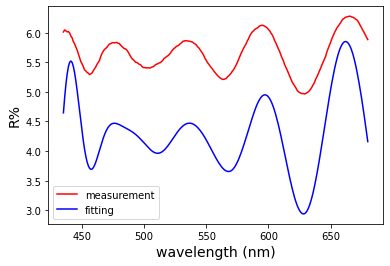

In [97]:
wl_ITO = np.linspace(435,680,246)
diamond = Design(
        {'a': 'air'}, [
            {'m': 'Acrylic', 'd': 1949.98345161},
            {'m': 'SiN', 'd': 27.79349366},
            {'m': 'SiO2', 'd': 20.18145273},
            {'m': 'ITO', 'd': 84.38011889},
            {'m': 'SiO2', 'd': 24.89553729},
            {'m': 'SiN', 'd': 22.82877788}
        ], {'s': 'sodalime'}, wl_ITO, 5)
R_d = diamond.R()
Ra = RA[35:-20]
plt.plot(wl_ITO, Ra, 'r-' ,label = 'measurement')
plt.plot(wl_ITO, 100*R_d, 'b-' ,label = 'fitting')
plt.ylabel("R%", fontsize = 14)
plt.xlabel("wavelength (nm)", fontsize = 14)
plt.legend(loc = "best")
plt.show()

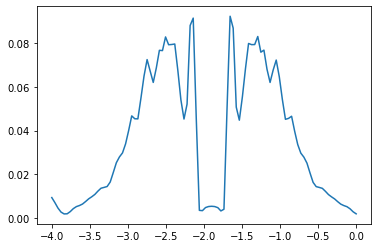

In [62]:
wl = np.linspace(430, 680, 200)
aR = []
def avgR(R1, R2, wa):
    return sum(abs(R1-R2))/np.size(wa)
n = np.linspace(-4, 0, 100)

for ni in n:
    def acrylic_h(m, x):
        n = (1.9+ni)*np.ones(np.size(x))
        k = 0*np.ones(np.size(x))
        return n, k

    ad1 = Design(
        {'a': 'sodalime'}, [
            {'m': 'ITO', 'd':20},
            {'m': 'acrylic_h', 'd':1000},
        ], {'s': 'sodalime'}, wl)
    ad2 = Design(
        {'a': 'sodalime'}, [
            {'m': 'acrylic_h', 'd':1020},
        ], {'s': 'sodalime'}, wl)
    R1 = ad1.R()
    R2 = ad2.R()
    aR.append(avgR(R1, R2, wl))
    
plt.plot(n, aR)
#plt.plot(wl, R1)
#plt.plot(wl, R2)
plt.show()